In [1]:
import sys
sys.path.insert(0, '../python_scripts')
import json
import glob
import h_gen
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import utils
import importlib
import meta
metadata = utils.load("./variables/metadata.p")
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import os
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
from shutil import copyfile
import threading
import PIL
importlib.reload(utils)
importlib.reload(meta)
from keras.preprocessing.image import img_to_array,array_to_img

Using Theano backend.
DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpelx5d_ix/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpelx5d_ix/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)
C:\Program Files\Anaconda3\lib\site-packages\theano\sandbox\cuda\__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
import theano.sandbox.cuda.basic_ops as sbcuda
sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0] /(1024**3)

0.08145446702837944

In [3]:
def create_cust1(nb_channels = 512):
    img_input = Input(shape=(nb_channels,) + (None,None)) 
    x = BatchNormalization(axis=1)(img_input)
    nb_output_channels = 512
    x = Convolution2D(nb_output_channels, 1, 1, activation='relu')(x)
    x = GlobalMaxPooling2D()(x)
    return Model(img_input, x), nb_output_channels

In [4]:
def create_cust2(nb_channels):
    img_input = Input(shape=(nb_channels,)) 
    x = BatchNormalization(axis=1)(img_input)
    x = Dense(256)(x)
    x = Dense(8)(x)
    return Model(img_input, x)

In [5]:
def create_complete_network(nb_branches = 2):
    
    # Our three networks, all the weights will be shared.
    vgg = VGG16(include_top=False)
    cust1, nb_channels  = create_cust1(512)
    cust2 = create_cust2(nb_channels)
    
    
    inputs = [Input(shape=(3, None, None)) for _ in range(nb_branches)]
    vgg_outs = [vgg(x) for x in inputs]
    cust1_outs = [cust1(x) for x in vgg_outs]
    
    reshaped = [Reshape((1, nb_channels))(x) for x in cust1_outs]
    
    # We merge and complete the max pooling operation
    merge_out = Merge(mode='concat', concat_axis=1)(reshaped)

    complete_max_pool = GlobalMaxPooling1D()(merge_out)
    
    
    predictions = cust2(complete_max_pool)
    
    
    return Model(inputs, predictions)

In [64]:
model = create_complete_network(nb_branches = 2)

In [6]:
def generator():
    while True:
        X = [np.zeros((2,3,100,110)) for _ in range(2)]
        Y = np.array([[0,1,0,0,0,0,0,0] for _ in range(2)])
        yield X, Y

In [76]:
model.compile(optimizer="sgd", loss="mse")

In [77]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_20 (InputLayer)            (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
input_21 (InputLayer)            (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
vgg16 (Model)                    (None, 512, None, Non 14714688    input_20[0][0]                   
                                                                   input_21[0][0]                   
____________________________________________________________________________________________________
model_10 (Model)                 (None, 512)           264704      vgg16[1][0]             

In [79]:
model.fit_generator(generator(), nb_epoch=2, samples_per_epoch=10, pickle_safe=True)

AttributeError: Can't pickle local object 'generator_queue.<locals>.data_generator_task'

In [7]:
# This will return the type of rectangle to use
class CustomIterator(object):

    def __init__(self, batch_size, nb_branches):
        self.batch_size = batch_size
        self.nb_branches = nb_branches
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(batch_size, nb_branches)

    def _flow_index(self, batch_size, nb_branches):
        up_lim = 300
        low_lim = 50
        
        matrix_indicators = np.zeros((batch_size, nb_branches))
        range_of_sizes = np.arange(low_lim, up_lim)
        
        probas = np.arange(up_lim-low_lim)[::-1]/np.sum(np.arange(up_lim-low_lim))
        
        while 1:
            
            sizes = np.random.choice(range_of_sizes, 2*nb_branches, p=probas)
            rectangle_sizes = np.reshape(sizes, (nb_branches, 2))
            
            # We need to know the labels:
            labels = np.random.choice(8, batch_size)
            
            matrix_indicators[:,0] = labels
            
            for i, label in enumerate(labels):
                
                # If the label is Nof
                if label == 0:
                    matrix_indicators[i,1:] = np.random.choice([0, 8] ,nb_branches-1,p=[0.75,0.25])
                
                # If the label is a fish:
                else:
                    matrix_indicators[i,1:] = np.random.choice([label, 0, 8] ,nb_branches-1,p=[0.6,0.2,0.2])

            yield matrix_indicators, rectangle_sizes,

    def __iter__(self):
        # needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)

In [8]:
import random
random.choice(list(metadata.items()))

('img_06767.jpg',
 {'angle': -149.43373011044548,
  'class': 'ALB',
  'code': 2,
  'filename': 'img_06767.jpg',
  'head_tail': [{'x': 376.713502711279, 'y': 167.4282234272351},
   {'x': 626.1815556178593, 'y': 314.765060043202}],
  'height': 720,
  'ht_first': True,
  'path': './train/ALB/img_06767.jpg',
  'rectangles': [{'height': 185.0000000000008,
    'width': 277.00000000000125,
    'x': 356.0000000000016,
    'y': 152.00000000000068}],
  'width': 1280})

In [9]:
importlib.reload(utils)
importlib.reload(meta)

<module 'meta' from 'C:\\Users\\yolo\\Desktop\\fish\\meta.py'>

In [10]:
cluster_0 = meta.get_cluster_data("cluster_0.p")
cluster_1 = meta.get_cluster_data("cluster_1.p")

In [11]:
reverse_classes_dictionary = meta.get_reverse_classes_dictionary()

In [12]:
def load_crop_resize_no_fish(img_path,rect_size):
    from keras.preprocessing.image import img_to_array
    img = Image.open(img_path)
    W,H = img.size
    w,h = rect_size 
    img = img_to_array(img)
    x = int(np.random.uniform(0,W-w))
    y = int(np.random.uniform(0,H-h))
    return img[:,y:y+h,x:x+w]

def load_crop_resize_fish(img_path,rdn_r,rect_size,option):
    from keras.preprocessing.image import img_to_array
    img = Image.open(img_path)
    W,H = img.size
    x,y,w,h = rdn_r
    if option == 0:
        return img_to_array(img.crop((x,y,x+w,y+h)).resize((rect_size[0],rect_size[1]), PIL.Image.ANTIALIAS))
    if option == 1:
        w0 = min(w,rect_size[0])
        h0 = min(h,rect_size[1])
        if w < rect_size[0]:
            x = np.random.uniform(x,x+rect_size[1]-w)
        if h < rect_size[1]:
            y = np.random.uniform(y,y+rect_size[0]-h)
        return img_to_array(img.crop((x,y,x+rect_size[0],y+rect_size[1])))
    if option == 2:
        img = Image.open(img_path)
        #print(img.size)
        img0 = img_to_array(img)
        #print(x+w,y+h,w,h)
        
        ####### THERE IS AN ERROR HERE ########################################
        #if w > 1280 and h < 720:
        #    img0 = img_to_array(img.crop((np.max([x,0]),np.max([y,0]),np.min([np.max([x,0])+w,1280]),720)))
        #if w < 1280 and h > 720:
        #    img0 = img_to_array(img.crop((np.max([x,0]),np.max([y,0]),1280,np.min([np.max([y,0])+h,720]))))
        #if w > 1280 and h > 720:
        #    img0 = img_to_array(img.crop((np.max([x,0]),np.max([y,0]),1280,720)))                                  
        #if w < 1280 and h < 720:
        img0 = img_to_array(img.crop((np.max([x,0]),np.max([y,0]),np.min([np.max([x,0])+w,W]),np.min([np.max([y,0])+h,H]))))
        ####### THERE IS AN ERROR HERE ########################################
        
        shape = img0.shape
        #print(shape)
        return img0,shape[1],shape[2]


In [13]:
class DiskArrayIterator(CustomIterator):
    
    def __init__(self, batch_size, nb_branches, metadata,cluster0,cluster1,reverse_classes_dictionary,pourcentage,option=0):
        self.batch_size=batch_size
        self.nb_branches=nb_branches
        self.cluster0 = cluster0
        self.cluster1 = cluster1
        self.metadata = metadata
        self.prt = pourcentage
        self.reverse_classes_dictionary = reverse_classes_dictionary
        self.option = option
        
        # We need to classify filenames by class
        """by_class = [[] for _ in range(8)]
        for key, v in metadata.items():
            
            # We check for any potential bug
            if v["code"] != 0 and ("rectangles" not in v or len(v["rectangles"]) == 0):
                continue
                
            by_class[v["code"]].append(key)
            
        self.by_class = by_class"""
        
        super(DiskArrayIterator, self).__init__(batch_size, nb_branches)

    def next(self):
        with self.lock:
            indicators, rectangle_sizes = next(self.index_generator)
            labels = utils.to_categorical(indicators[:,0],8)
            X = [np.zeros((len(indicators),3,rect_size[1],rect_size[0])) for rect_size in rectangle_sizes]
            if self.option == 2:
                X = [np.zeros((len(indicators),3,1800,1200)) for rect_size in rectangle_sizes]
                W_max = [[] for i in range(len(rectangle_sizes)) ]
                H_max = [[] for i in range(len(rectangle_sizes)) ]
            for i,indicator in enumerate(indicators):
                for j,rect_size in enumerate(rectangle_sizes):
                    wanted_class = str(int(indicator[j]))
                    cluster_choice = np.random.choice([0,1] ,p=[0.5,0.5])
                    rect_size = rectangle_sizes[j]
                    if cluster_choice == 0 :
                        if wanted_class== '0':
                            random_img_name = np.random.choice(self.cluster0[self.reverse_classes_dictionary[wanted_class]]) 
                            meta = self.metadata[random_img_name]
                            #print(self.reverse_classes_dictionary[wanted_class],random_img_name)
                            if self.option != 2:
                                X[j][i,:,:] = load_crop_resize_no_fish(meta['path'],rect_size)
                            else:
                                X[j][i,:,:rect_size[1],:rect_size[0]] = load_crop_resize_no_fish(meta['path'],rect_size)
                                W_max[j].append(rect_size[0])
                                H_max[j].append(rect_size[1])
                                
                                
                            
                            
                        elif wanted_class == '8':
                            pass
                        
                        else:
                            random_img_name = np.random.choice(self.cluster1[self.reverse_classes_dictionary[wanted_class]]) 
                            meta = self.metadata[random_img_name]
                            #print(self.reverse_classes_dictionary[wanted_class],random_img_name)
                            if len(meta['rectangles']) > 0:
                                rdn_r = np.random.choice(meta['rectangles'])
                                x = int(rdn_r['x'] + np.random.uniform(-self.prt,0)*rdn_r['x'])
                                y = int(rdn_r['y'] + np.random.uniform(-self.prt,0)*rdn_r['y'])
                                w = int(rdn_r['width'] + np.random.uniform(0,2*self.prt)*rdn_r['width'])
                                h = int(rdn_r['height'] + np.random.uniform(0,2*self.prt)*rdn_r['height'])
                                if self.option != 2:
                                    X[j][i,:,:] = load_crop_resize_fish(meta['path'],[x,y,w,h],rect_size,self.option)
                                else:
                                    #print(cluster_choice,random_img_name)
                                    ##### ICICICIC
                                    #print(self.option)
                                    img,h,w = load_crop_resize_fish(meta['path'],[x,y,w,h],rect_size,self.option)
                                    #w,h = int(w),int(h)
                                    X[j][i,:,:h,:w]=img
                                    W_max[j].append(w)
                                    H_max[j].append(h)                                    
                                    
                    
                    else :
                        if wanted_class=='0':
                            random_img_name = np.random.choice(self.cluster1[self.reverse_classes_dictionary[wanted_class]]) 
                            meta = self.metadata[random_img_name]
                            #print(self.reverse_classes_dictionary[wanted_class],random_img_name)
                            if self.option != 2:
                                X[j][i,:,:] = load_crop_resize_no_fish(meta['path'],rect_size)
                            else:
                                X[j][i,:,:rect_size[1],:rect_size[0]] = load_crop_resize_no_fish(meta['path'],rect_size)
                                W_max[j].append(rect_size[0])
                                H_max[j].append(rect_size[1])                            
                            
                        elif wanted_class == '8':
                            pass
                        
                        else:
                            random_img_name = np.random.choice(self.cluster1[self.reverse_classes_dictionary[wanted_class]]) 
                            meta = self.metadata[random_img_name]
                            #print(self.reverse_classes_dictionary[wanted_class],random_img_name)
                            if len(meta['rectangles']) > 0:
                                rdn_r = np.random.choice(meta['rectangles'])
                                x = int(rdn_r['x'] + np.random.uniform(-self.prt,0)*rdn_r['x'])
                                y = int(rdn_r['y'] + np.random.uniform(-self.prt,0)*rdn_r['y'])
                                w = int(rdn_r['width'] + np.random.uniform(0,2*self.prt)*rdn_r['width'])
                                h = int(rdn_r['height'] + np.random.uniform(0,2*self.prt)*rdn_r['height'])
                                if self.option != 2:
                                    X[j][i,:,:] = load_crop_resize_fish(meta['path'],[x,y,w,h],rect_size,self.option)
                                else:
                                    #print(cluster_choice,random_img_name)
                                    ##### ICICICIC
                                    img,h,w = load_crop_resize_fish(meta['path'],[x,y,w,h],rect_size,self.option)
                                    #w,h = int(w),int(h)
                                    X[j][i,:,:h,:w]=img
                                    W_max[j].append(w)
                                    H_max[j].append(h)
            if self.option == 2:
                X = [X[i][:,:,:np.max(H_max[i]),:np.max(W_max[i])] for i in range(len(rectangle_sizes))]
            return X,indicators,labels
        
        
        

In [39]:
for X,indicators,labels in DiskArrayIterator(8,3,metadata,cluster_0,cluster_1, reverse_classes_dictionary, 0.3, option=2):
    break

In [40]:
[x.shape for x in X]

[(8, 3, 370, 285), (8, 3, 209, 305), (8, 3, 194, 201)]

[[ 4.  4.  4.]
 [ 1.  1.  8.]
 [ 2.  2.  0.]
 [ 7.  8.  8.]
 [ 0.  0.  0.]
 [ 4.  4.  0.]
 [ 5.  5.  0.]
 [ 2.  0.  0.]]


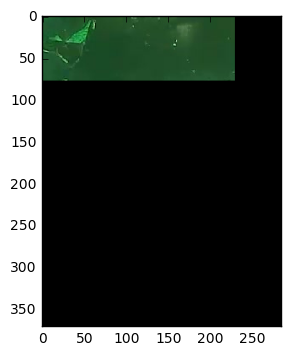

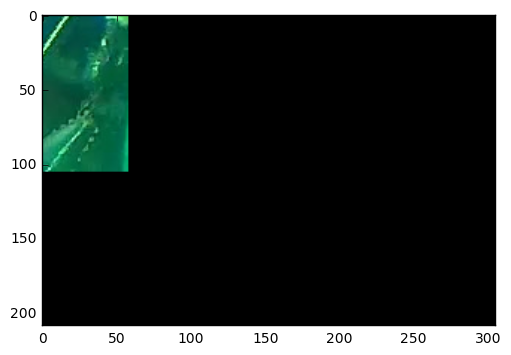

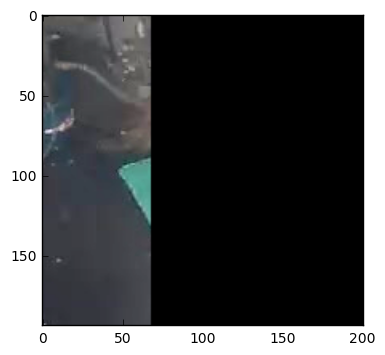

In [41]:
print(indicators)
for arr in X:
    plt.figure()
    img  = array_to_img(arr[2])
    plt.imshow(img)
    plt.show()
    

In [82]:
import multiprocessing
import time
import sys

def daemon():
    p = multiprocessing.current_process()
    print ('Starting:', p.name, p.pid)
    sys.stdout.flush()
    time.sleep(2)
    print ('Exiting :', p.name, p.pid)
    sys.stdout.flush()

def non_daemon():
    p = multiprocessing.current_process()
    print ('Starting:', p.name, p.pid)
    sys.stdout.flush()
    print ('Exiting :', p.name, p.pid)
    sys.stdout.flush()


d = multiprocessing.Process(name='daemon', target=daemon)
d.daemon = True

n = multiprocessing.Process(name='non-daemon', target=non_daemon)
n.daemon = False

d.start()
time.sleep(1)
n.start()